In [54]:
%matplotlib inline
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from datetime import datetime
import logging
import itertools
# Set the style for plots
plt.style.use('ggplot')

In [55]:
# Read the data from a csv file and convert the 'Date' column to datetime format
df = pd.read_csv('sp500_index.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [56]:
df.tail()

,Date,S&P500
2512,2023-05-31,4179.83
2513,2023-06-01,4221.02
2514,2023-06-02,4282.37
2515,2023-06-05,4273.79
2516,2023-06-06,4283.85


In [57]:
# Generate a profiling report for the data frame
profile = ProfileReport(df, title="Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

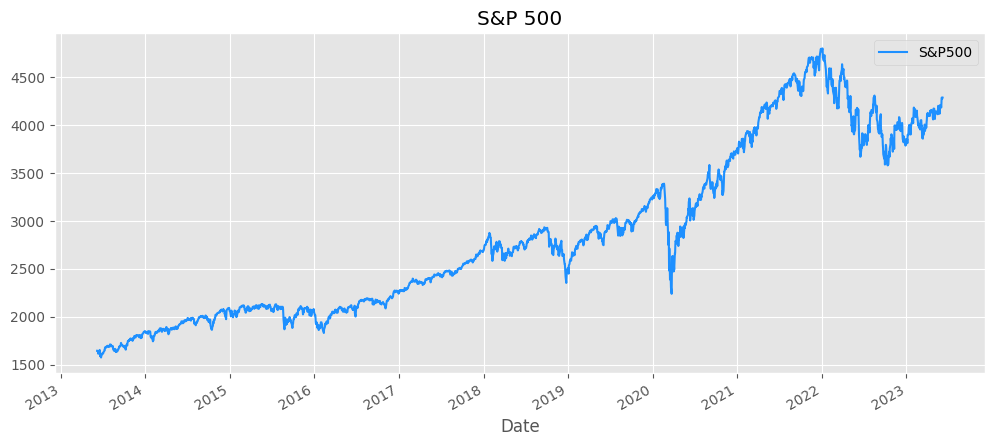

In [58]:
# Plot the 'S&P500' column against the 'Date' column
df.plot(style='-',
        figsize=(12,5),
        x='Date',
        y='S&P500',
        title='S&P 500',
        color='dodgerblue')
plt.show()

In [59]:
# Rename the columns for compatibility with Prophet library
df_prophet = df.rename(columns={'Date':'ds',
                                'S&P500':'y'})

In [60]:
df_prophet.head()

,ds,y
0,2013-06-07,1643.38
1,2013-06-10,1642.81
2,2013-06-11,1626.13
3,2013-06-12,1612.52
4,2013-06-13,1636.36


In [61]:
%%time
# Create and fit a Prophet model with specified parameters
model = Prophet(interval_width=0.95, weekly_seasonality=False)
# Add US holidays
model.add_country_holidays(country_name='US')
model.fit(df_prophet)

CPU times: user 155 ms, sys: 21.2 ms, total: 176 ms
Wall time: 1.27 s


In [62]:
# Create dataframe for 30 business days ahead, make future predictions and display the last 5 rows of the forecast data frame
future = model.make_future_dataframe(periods=30, freq='B')
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2542,2023-07-12,3892.918826,3616.359403,4118.562402,3873.887015,3907.959007,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-13.453109,-13.453109,-13.453109,0.0,0.0,0.0,3879.465717
2543,2023-07-13,3892.203833,3621.453115,4140.347010,3871.652626,3908.602458,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-10.152198,-10.152198,-10.152198,0.0,0.0,0.0,3882.051635
2544,2023-07-14,3891.488840,3628.277829,4146.735138,3869.407185,3908.907588,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-6.972717,-6.972717,-6.972717,0.0,0.0,0.0,3884.516123
2545,2023-07-17,3889.343861,3648.953158,4160.624860,3865.399782,3907.966220,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.658115,1.658115,1.658115,0.0,0.0,0.0,3891.001976
2546,2023-07-18,3888.628868,3636.649203,4168.145737,3862.822366,3908.454838,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.195295,4.195295,4.195295,0.0,0.0,0.0,3892.824163


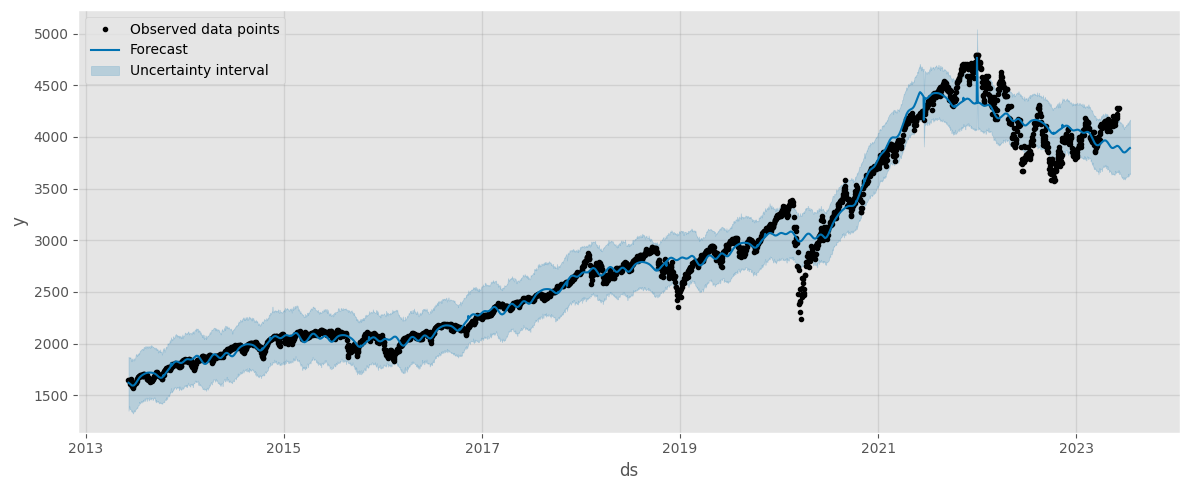

In [63]:
# Plot the forecasted values
fig, ax = plt.subplots(figsize=(12,5))
model.plot(forecast, ax=ax, include_legend=True)
plt.show()

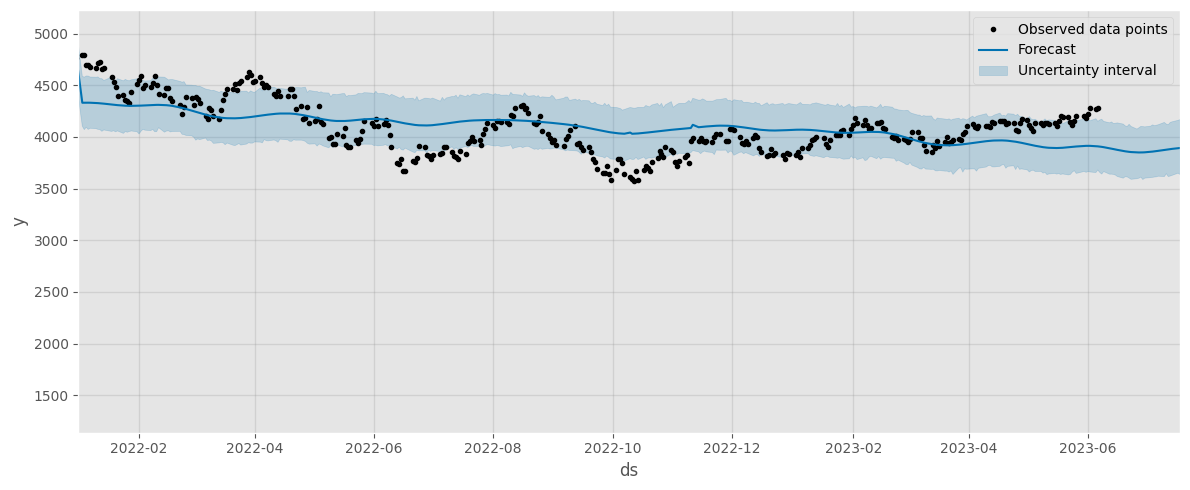

In [64]:
# Plot the forecasted values since early 2022
min_value = datetime(2022,1,1)
max_value = forecast['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model.plot(forecast, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

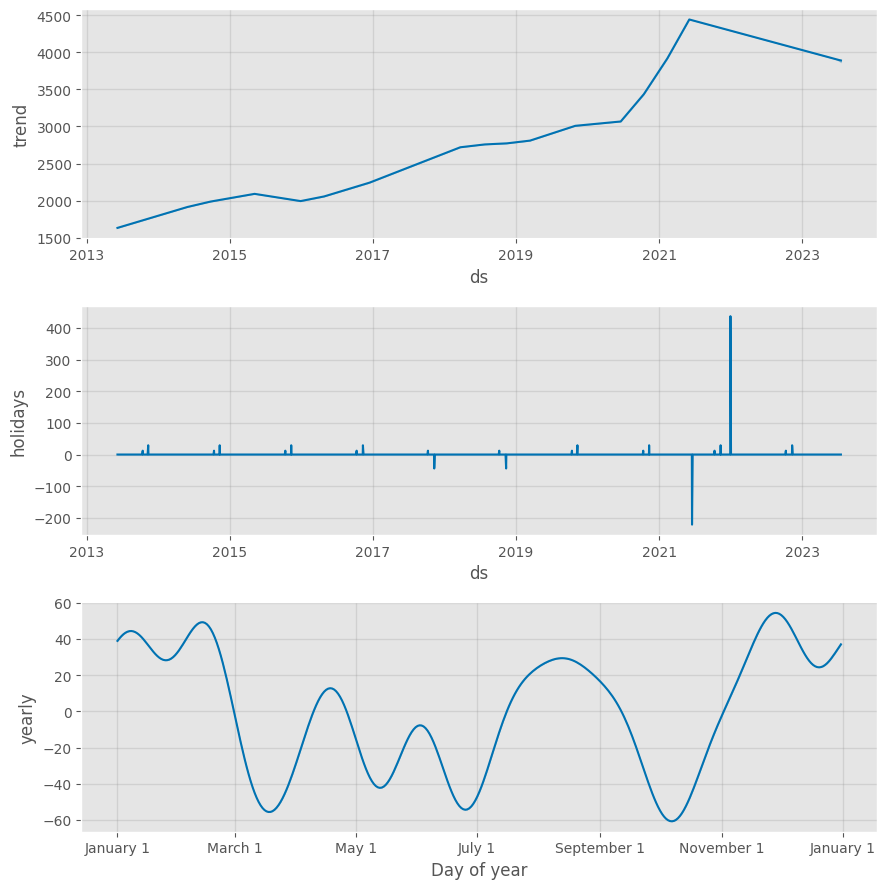

In [65]:
# Plot the components of the forecast (trend, holidays and yearly seasonality)
model.plot_components(forecast)
plt.show()

In [66]:
%%time
# Perform cross-validation on the fitted model and calculate performance metrics
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv = cross_validation(model, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False
forecast_cv_p = performance_metrics(forecast_cv)
forecast_cv_p.head()

CPU times: user 523 ms, sys: 95.9 ms, total: 618 ms
Wall time: 15.4 s


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,55819.601652,236.261723,145.897614,0.044285,0.026028,0.043085,0.525367
1,10 days,58071.756200,240.980821,148.871337,0.045372,0.028116,0.044134,0.498593
2,11 days,58623.054201,242.121982,151.399588,0.046281,0.030515,0.045058,0.476709
3,12 days,60514.670027,245.997297,154.704051,0.047228,0.032000,0.045988,0.454215
4,13 days,61960.888073,248.919441,157.649480,0.048148,0.033801,0.046924,0.431744


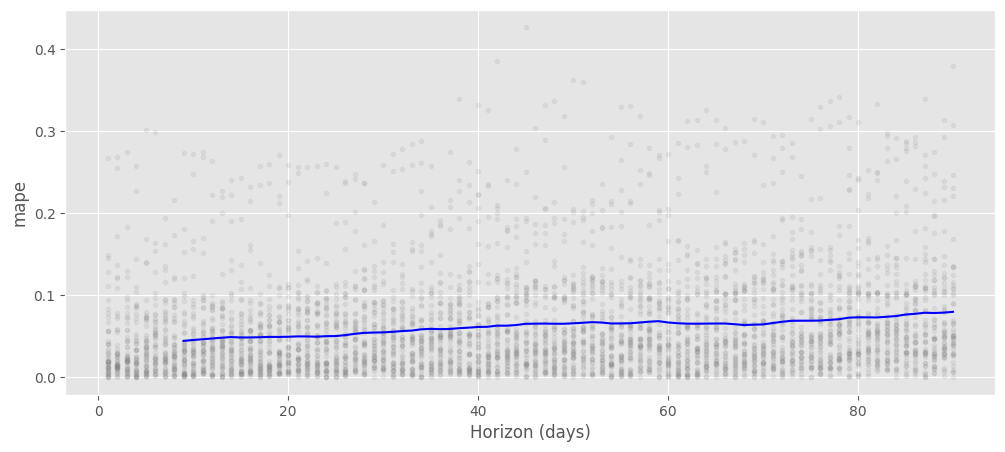

In [67]:
# Plot cross-validation metric (MAPE) over time horizon
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv, ax=ax, metric='mape')
plt.show()

In [68]:
%%time
# Perform grid search to find optimal hyperparameters for the model and display tuning results and best parameters found.
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    logging.getLogger("cmdstanpy").disabled = True 
    m = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(m , horizon='30 days', parallel="processes")
    logging.getLogger("cmdstanpy").disabled = False
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)
best_params = all_params[np.argmin(rmses)]
print(best_params)

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  292.989058
1                     0.001                     0.10  292.698775
2                     0.001                     1.00  292.122592
3                     0.001                    10.00  292.167317
4                     0.010                     0.01  283.931028
5                     0.010                     0.10  283.723781
6                     0.010                     1.00  283.599020
7                     0.010                    10.00  283.824622
8                     0.100                     0.01  257.273471
9                     0.100                     0.10  257.906550
10                    0.100                     1.00  257.966451
11                    0.100                    10.00  257.808781
12                    0.500                     0.01  258.037890
13                    0.500                     0.10  259.795396
14                    0.5

In [69]:
%%time
# Create and fit a Prophet model with best parameters from grid search
model_best = Prophet(interval_width=0.95, weekly_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
# Add US holidays
model_best.add_country_holidays(country_name='US')
model_best.fit(df_prophet)
forecast_best = model_best.predict(future)

13:06:55 - cmdstanpy - INFO - Chain [1] start processing
13:06:56 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 978 ms, sys: 308 ms, total: 1.29 s
Wall time: 1.48 s


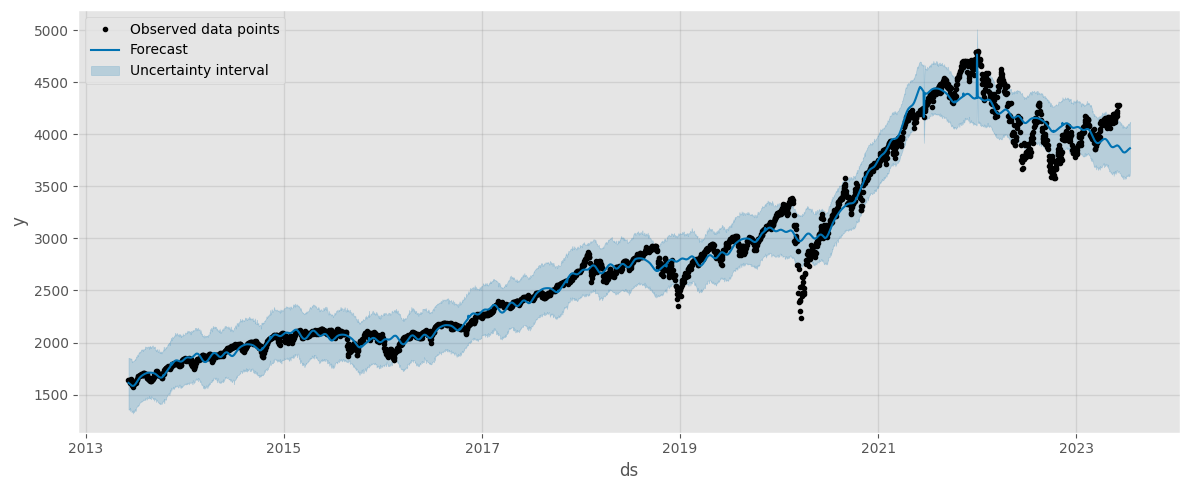

In [70]:
# Plot the forecasted values
fig, ax = plt.subplots(figsize=(12,5))
model_best.plot(forecast_best, ax=ax, include_legend=True)
plt.show()

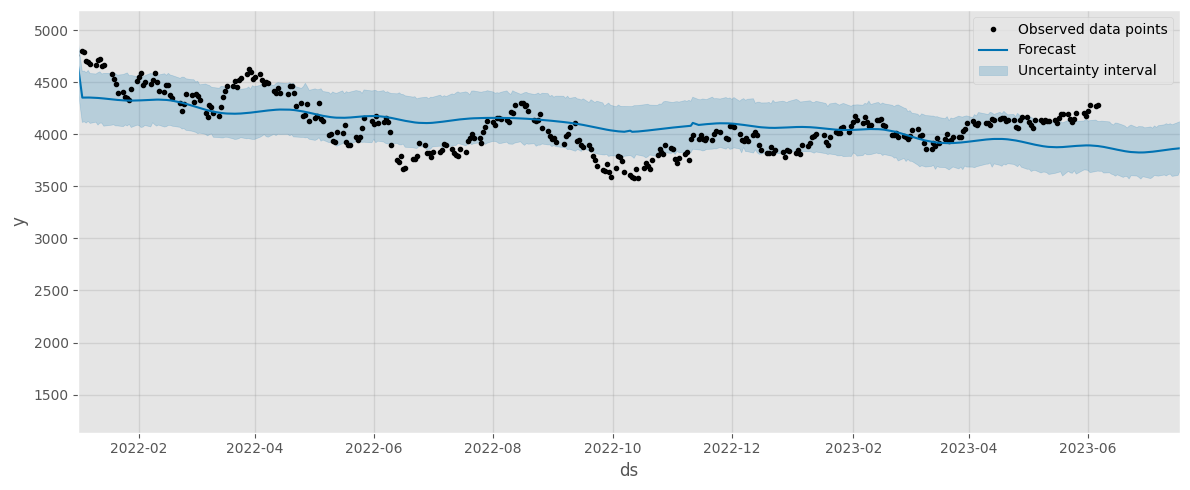

In [71]:
# Plot the forecasted values since early 2022
min_value = datetime(2022,1,1)
max_value = forecast_best['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model_best.plot(forecast_best, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

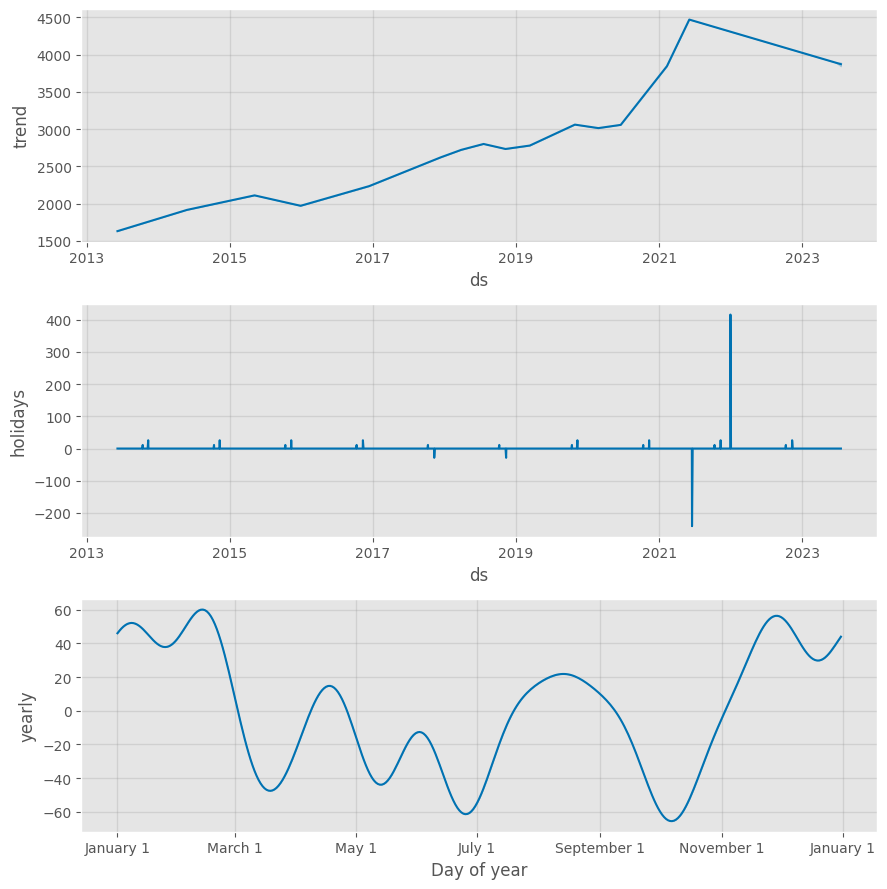

In [72]:
# Plot the components of the forecast (trend, holidays and yearly seasonality)
model_best.plot_components(forecast_best)
plt.show()

In [73]:
%%time
# Perform cross-validation on the fitted model and calculate performance metrics
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv_best = cross_validation(model_best, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False
forecast_best_perf = performance_metrics(forecast_cv_best)
forecast_best_perf.head()

CPU times: user 476 ms, sys: 87.2 ms, total: 563 ms
Wall time: 20.5 s


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,52958.602328,230.127361,141.253287,0.042727,0.025322,0.041606,0.505232
1,10 days,55024.944191,234.573963,144.791611,0.044032,0.026792,0.042887,0.476084
2,11 days,55485.797452,235.554235,147.329318,0.044940,0.029045,0.043804,0.460831
3,12 days,57292.987875,239.359537,150.176991,0.045643,0.029785,0.044489,0.456188
4,13 days,58609.597918,242.094192,152.651958,0.046336,0.030273,0.045212,0.438298


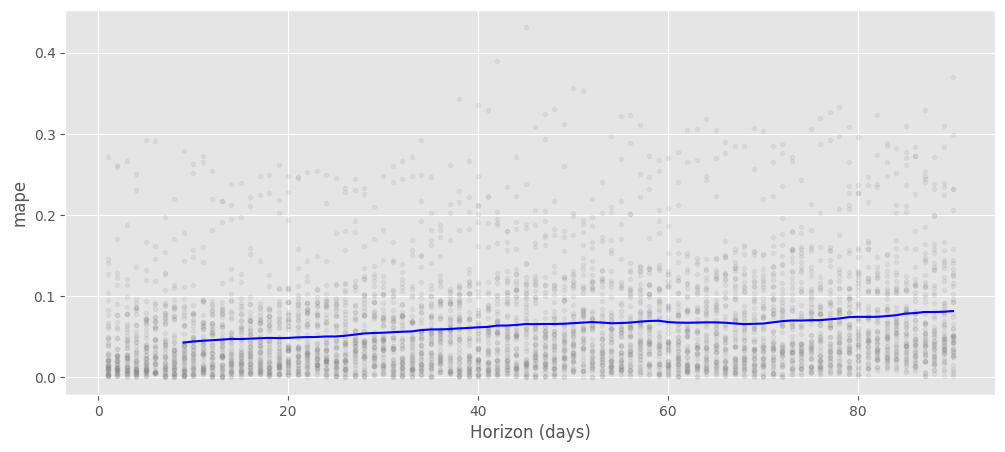

In [74]:
# Plot cross-validation metric (MAPE) over time horizon
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv_best, ax=ax, metric='mape')
plt.show()

In [75]:
%%time
# Create a Prophet model with best parameters from grid search and custom seasonality
model_best_season = Prophet(interval_width=0.95, weekly_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01)
model_best_season.add_seasonality(name='yearly', period=365, fourier_order=8)
# Add US holidays
model_best_season.add_country_holidays(country_name='US')
model_best_season.fit(df_prophet)
forecast_best_season = model_best_season.predict(future)

13:07:18 - cmdstanpy - INFO - Chain [1] start processing
13:07:19 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.09 s, sys: 286 ms, total: 1.37 s
Wall time: 1.53 s


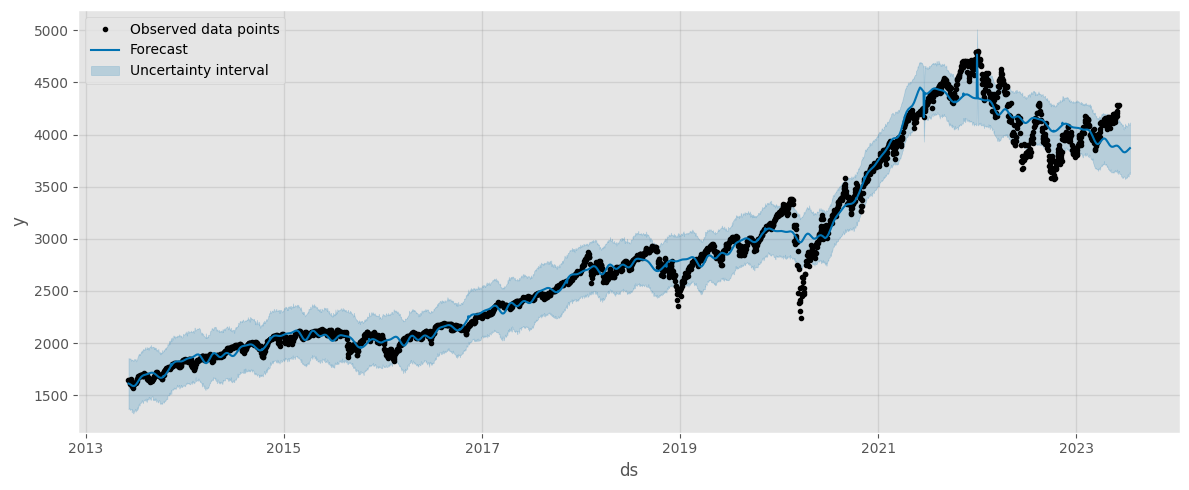

In [76]:
# Plot the forecasted values
fig, ax = plt.subplots(figsize=(12,5))
model_best_season.plot(forecast_best_season, ax=ax, include_legend=True)
plt.show()

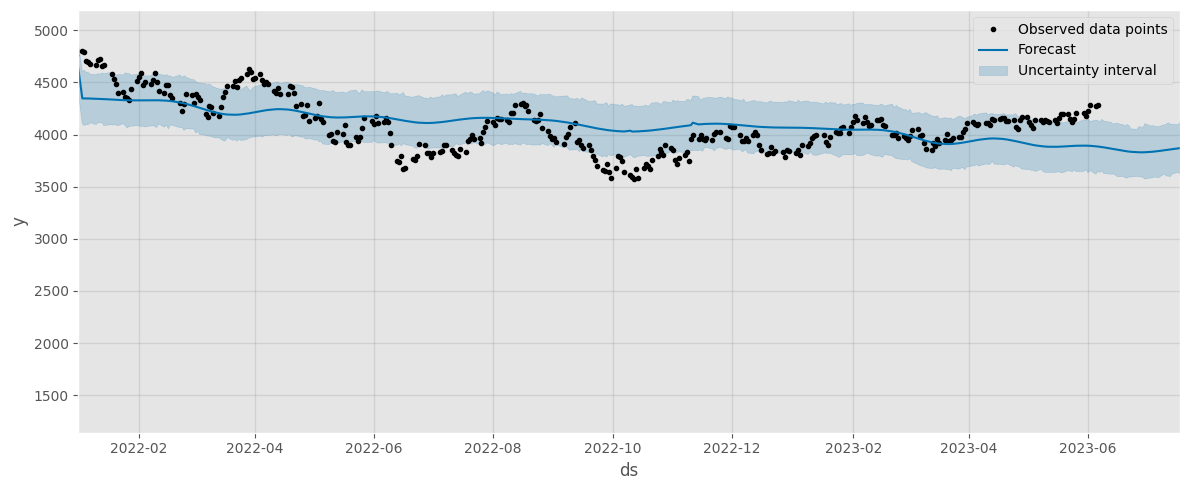

In [77]:
# Plot the forecasted values since early 2022
min_value = datetime(2022,1,1)
max_value = forecast_best_season['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model_best_season.plot(forecast_best_season, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

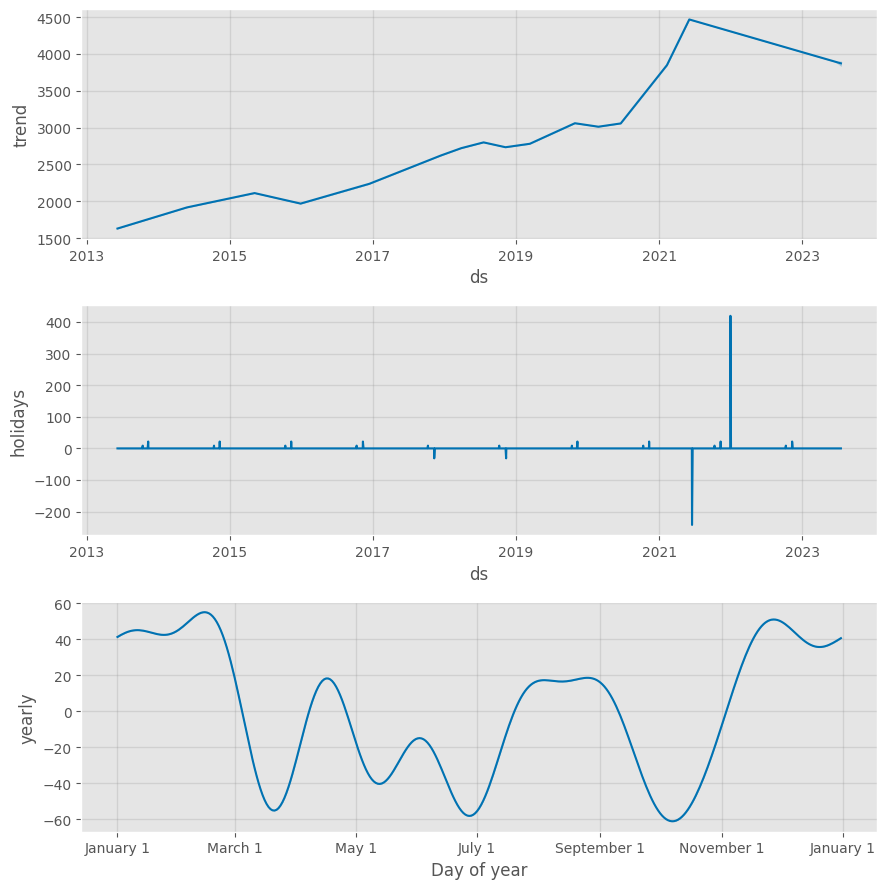

In [78]:
# Plot the components of the forecast (trend, holidays and yearly seasonality)
model_best_season.plot_components(forecast_best_season)
plt.show()

In [79]:
%%time
# Perform cross-validation on the fitted model and calculate performance metrics
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv_season = cross_validation(model_best_season, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False
forecast_season_perf = performance_metrics(forecast_cv_season)
forecast_season_perf.head()

CPU times: user 536 ms, sys: 45 ms, total: 581 ms
Wall time: 18.4 s


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,52155.495250,228.375776,140.286692,0.042426,0.025209,0.041325,0.516398
1,10 days,54112.011041,232.619885,143.571823,0.043642,0.027172,0.042518,0.485140
2,11 days,54531.892040,233.520646,145.925626,0.044478,0.028654,0.043363,0.469800
3,12 days,56340.731889,237.362027,148.842301,0.045211,0.029063,0.044077,0.465202
4,13 days,57664.927821,240.135228,151.423296,0.045944,0.030039,0.044841,0.447223


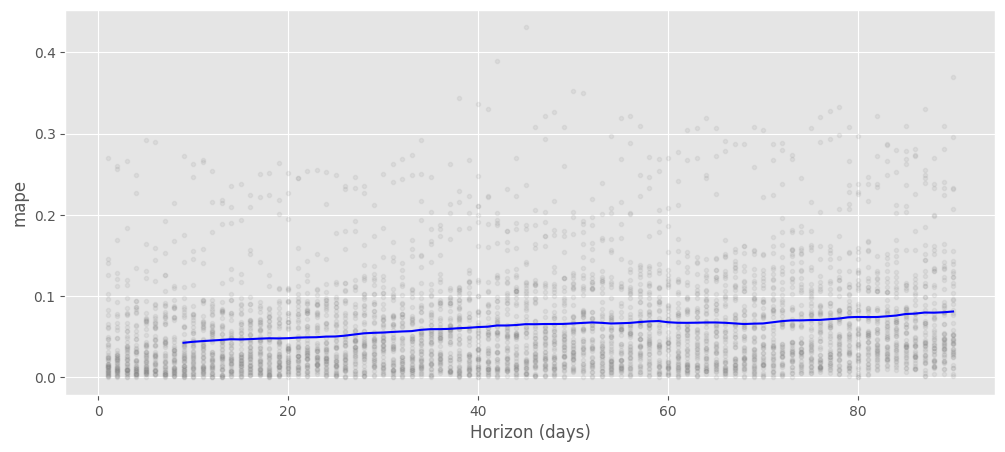

In [80]:
# Plot cross-validation metric (MAPE) over time horizon
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv_season, ax=ax, metric='mape')
plt.show()

In [81]:
# Create a DataFrame with information about COVID lockdowns
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
# Convert the dates in the DataFrame to datetime objects
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
# Calculate the number of days between the start and end of each lockdown
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [82]:
%%time
# Create a Prophet model with best parameters from grid search, custom seasonality and include the lockdown information as holidays
model_covid = Prophet(interval_width=0.95, weekly_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01, holidays=lockdowns)
model_covid.add_seasonality(name='yearly', period=365, fourier_order=8)
# Add US holidays
model_covid.add_country_holidays(country_name='US')
model_covid.fit(df_prophet)
forecast_covid = model_covid.predict(future)

13:07:40 - cmdstanpy - INFO - Chain [1] start processing
13:07:44 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 1.41 s, sys: 395 ms, total: 1.81 s
Wall time: 4.36 s


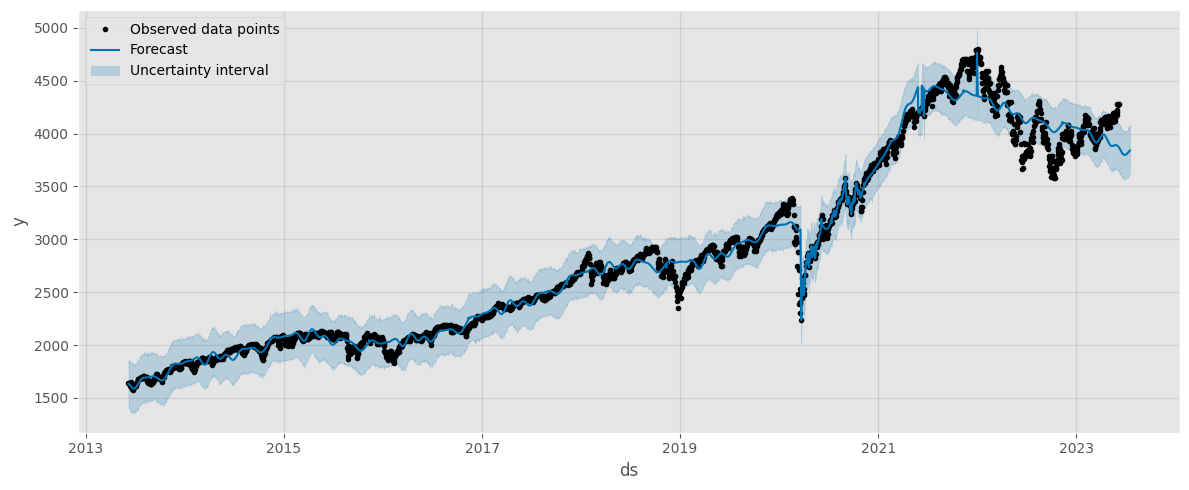

In [83]:
# Plot the forecasted values
fig, ax = plt.subplots(figsize=(12,5))
model_covid.plot(forecast_covid, ax=ax, include_legend=True)
plt.show()

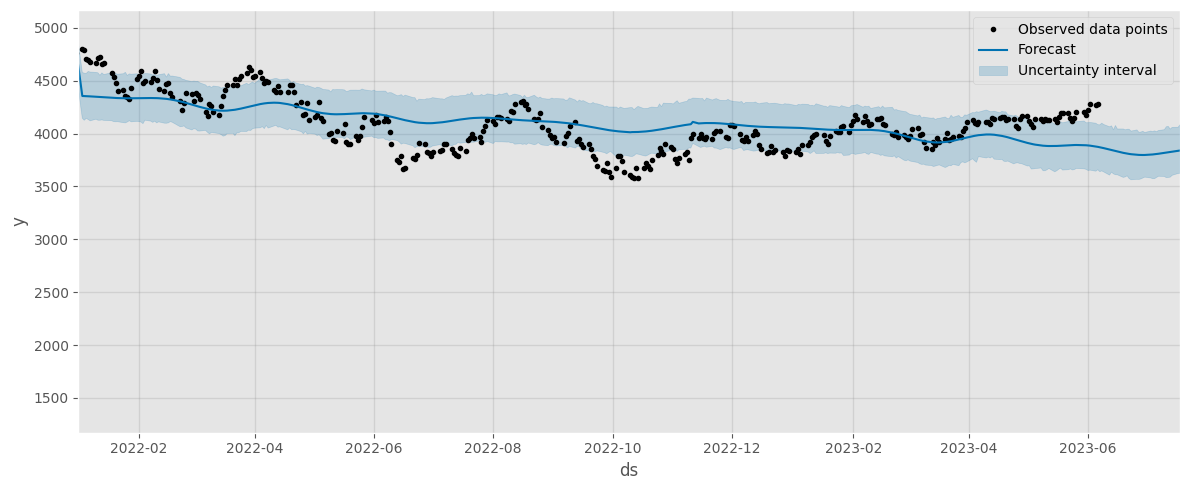

In [84]:
# Plot the forecasted values since early 2022
min_value = datetime(2022,1,1)
max_value = forecast_covid['ds'].max()
fig, ax = plt.subplots(figsize=(12,5))
model_covid.plot(forecast_covid, ax=ax, include_legend=True)
ax.set_xlim([min_value, max_value])
plt.show()

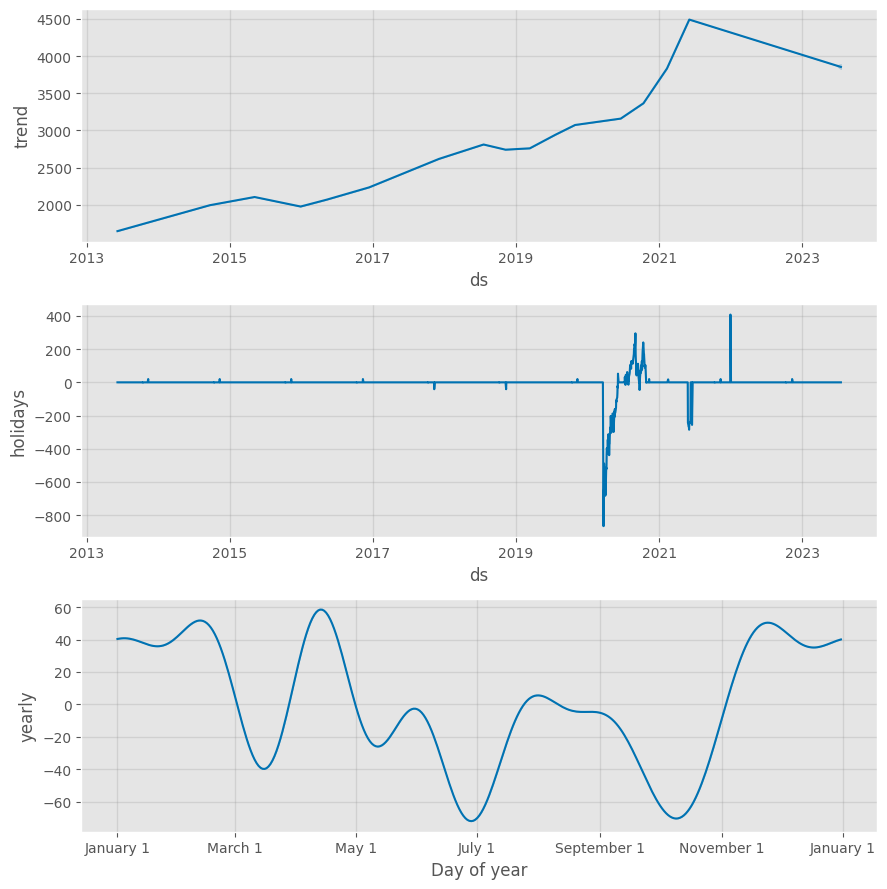

In [85]:
# Plot the components of the forecast (trend, holidays and yearly seasonality)
model_covid.plot_components(forecast_covid)
plt.show()

In [86]:
%%time
# Perform cross-validation on the fitted model and calculate performance metrics
logging.getLogger("cmdstanpy").disabled = True 
forecast_cv_covid = cross_validation(model_covid, horizon='90 days', parallel='processes')
logging.getLogger("cmdstanpy").disabled = False
forecast_covid_perf = performance_metrics(forecast_cv_covid)
forecast_covid_perf.head()

CPU times: user 566 ms, sys: 87.8 ms, total: 654 ms
Wall time: 1min 33s


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,46756.790276,216.233185,134.861252,0.041480,0.026252,0.040242,0.498549
1,10 days,48525.392894,220.284800,138.239778,0.042683,0.027899,0.041441,0.469269
2,11 days,49093.247391,221.569960,141.102839,0.043686,0.029447,0.042429,0.440743
3,12 days,50736.283465,225.247161,143.624721,0.044313,0.029638,0.043020,0.431525
4,13 days,51961.819909,227.951354,145.914365,0.044919,0.030700,0.043669,0.415919


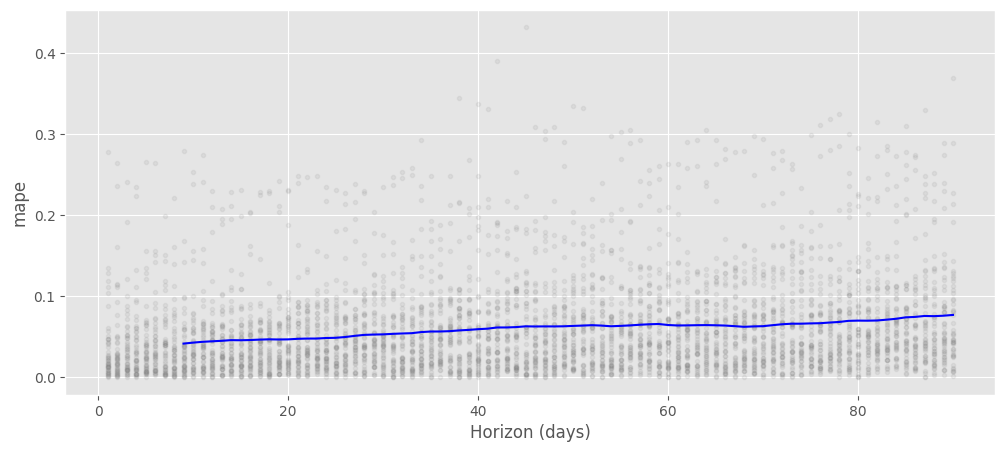

In [87]:
# Plot cross-validation metric (MAPE) over time horizon
fig, ax = plt.subplots(figsize=(12,5))
plot_cross_validation_metric(forecast_cv_covid, ax=ax, metric='mape')
plt.show()